In [1]:
import os #for using operating system-dependent functionality
import numpy as np # for numerical computations
import pandas as pd # for data manipulation and analysis
import matplotlib.pyplot as plt #for creating visualizations 
import seaborn as sns #for high-level interfaces, built on-top plt
import warnings
warnings.filterwarnings(action="ignore")

import librosa #for audio analysis
import librosa.display #for displaying audio data

from sklearn.preprocessing import MinMaxScaler #for feature scaling
from tqdm import tqdm, notebook,trange #functions/classes for displaying progress bars during iterations
from sklearn.linear_model import LogisticRegression # for logistic regression modeling

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

from keras.preprocessing import image
from keras import backend as K #pre-trained deep learning models for computer vision tasks
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential #to build sequential neural network models
from keras.layers import Flatten,BatchNormalization #DL layers
from keras.layers import Dense,Dropout
from keras.optimizers import Adam # optimizer used in training
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

import plotly as px #for creating interactive visualizations
import plotly.graph_objects as go #for creating graph objects

from pylab import rcParams #to customize graph figure
rcParams['figure.figsize'] = 15,6
plt.style.use('fivethirtyeight')

In [2]:
#importing all 380,000 data entries to one file for treatment
file_paths = [
    "D:/AMINA/PFE24/datasets/commonvoice/cv-valid-train.csv",
    "D:/AMINA/PFE24/datasets/commonvoice/cv-other-train.csv",
    "D:/AMINA/PFE24/datasets/commonvoice/cv-invalid.csv",
    "D:/AMINA/PFE24/datasets/commonvoice/cv-valid-dev.csv",
    "D:/AMINA/PFE24/datasets/commonvoice/cv-other-dev.csv",
    "D:/AMINA/PFE24/datasets/commonvoice/cv-valid-test.csv",
    "D:/AMINA/PFE24/datasets/commonvoice/cv-other-test.csv",
]
dfs = []
for i in file_paths:
    df = pd.read_csv(i)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

output_file_path = os.path.join("D:/AMINA/PFE24/application", "data.csv")
df.to_csv(output_file_path, index=False)

df.head(2)

,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-train/sample-000000.mp3,learn to recognize omens and follow them the o...,1,0,NaN,NaN,NaN,NaN
1,cv-valid-train/sample-000001.mp3,everything in the universe evolved he said,1,0,NaN,NaN,NaN,NaN


In [3]:
#DATA CLEANING
#removing all lines without age, gender, and accent values + deleting unecessary columns
df = df.dropna(subset=['age'])
df = df[["filename","age","gender","accent"]]
df = df.dropna(subset=['gender'])
df = df.dropna(subset=['accent'])
cleanup_nums = {"age": {"teens":1,"twenties":2,"thirties":3,"fourties":4,"fifties":5,"sixties":6,"seventies":7,"eighties":8}}
df = df.replace(cleanup_nums)
df.head(2)

,filename,age,gender,accent
5,cv-valid-train/sample-000005.mp3,2,female,us
8,cv-valid-train/sample-000008.mp3,7,male,us


In [4]:
#AUDIO PROCESSING
#first: iterating through the audio folders and comparing with df["filename"] values
folder_paths = [
    "D:/AMINA/PFE24/datasets/commonvoice/cv-valid-train/",
    "D:/AMINA/PFE24/datasets/commonvoice/cv-valid-test/",
    "D:/AMINA/PFE24/datasets/commonvoice/cv-valid-dev/",
    "D:/AMINA/PFE24/datasets/commonvoice/cv-other-train/",
    "D:/AMINA/PFE24/datasets/commonvoice/cv-other-test/",
    "D:/AMINA/PFE24/datasets/commonvoice/cv-other-dev/",
    "D:/AMINA/PFE24/datasets/commonvoice/cv-invalid/"
]

for folder_path in folder_paths:
    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Check if the filename starts with the folder name
        if row["filename"].startswith(folder_path.split("/")[-2]):
            # Concatenate the folder path with the filename
            df.at[index, "filename"] = folder_path + row["filename"]
# Reset the index because it was ruined after combining the 7 csv and deleting multiple lin
df.reset_index(drop=True, inplace=True)
df.head(2)

,filename,age,gender,accent
0,D:/AMINA/PFE24/datasets/commonvoice/cv-valid-t...,2,female,us
1,D:/AMINA/PFE24/datasets/commonvoice/cv-valid-t...,7,male,us


In [5]:
# Save cleaned and manipulated data to CSV
data_csv_path = "D:/AMINA/PFE24/application/data.csv"
df.to_csv(data_csv_path, index=False)

In [6]:
df = pd.read_csv("D:/AMINA/PFE24/application/data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126108 entries, 0 to 126107
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   filename  126108 non-null  object
 1   age       126108 non-null  int64 
 2   gender    126108 non-null  object
 3   accent    126108 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.8+ MB


In [7]:
df.head(2)

,filename,age,gender,accent
0,D:/AMINA/PFE24/datasets/commonvoice/cv-valid-t...,2,female,us
1,D:/AMINA/PFE24/datasets/commonvoice/cv-valid-t...,7,male,us


118455


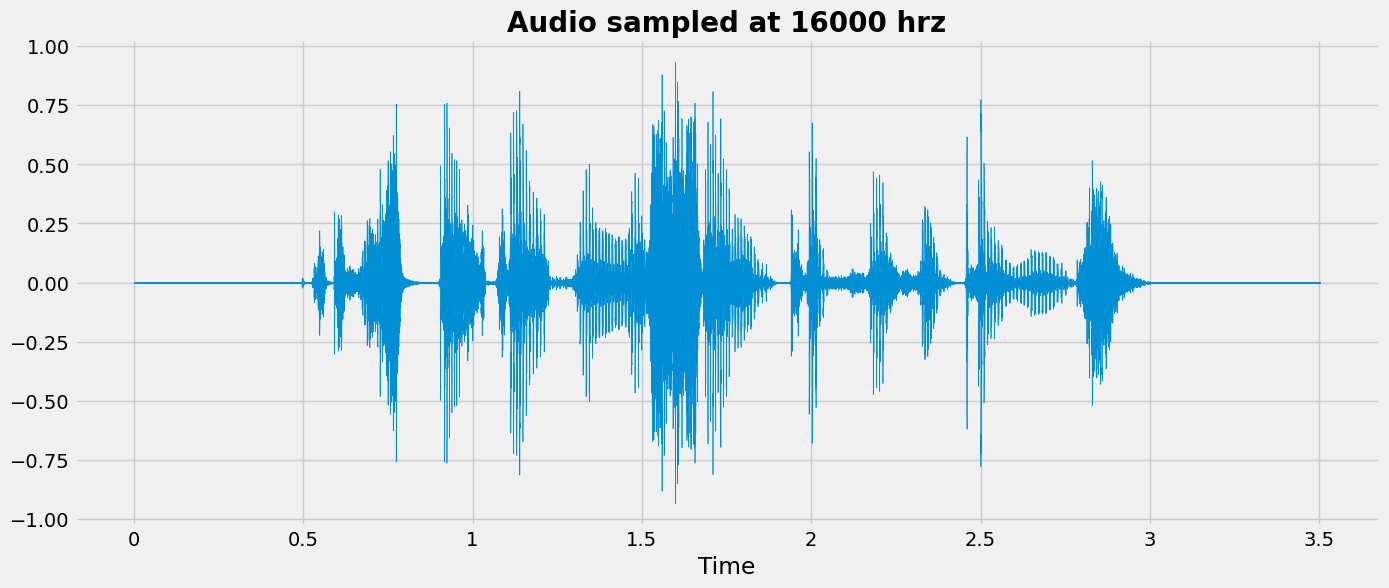

In [6]:
sample_rate = 16000 #16,000 Hz
idx = np.random.randint(0,len(df))
fl = df.filename[idx]
print(idx)
audio_array, sampling_rate = librosa.load(fl, sr=sample_rate)
plt.figure()
librosa.display.waveshow(audio_array, sr=sampling_rate)
plt.title('Audio sampled at {} hrz'.format(sample_rate),fontsize = 20, loc='center', fontdict=dict(weight='bold'))
plt.show()

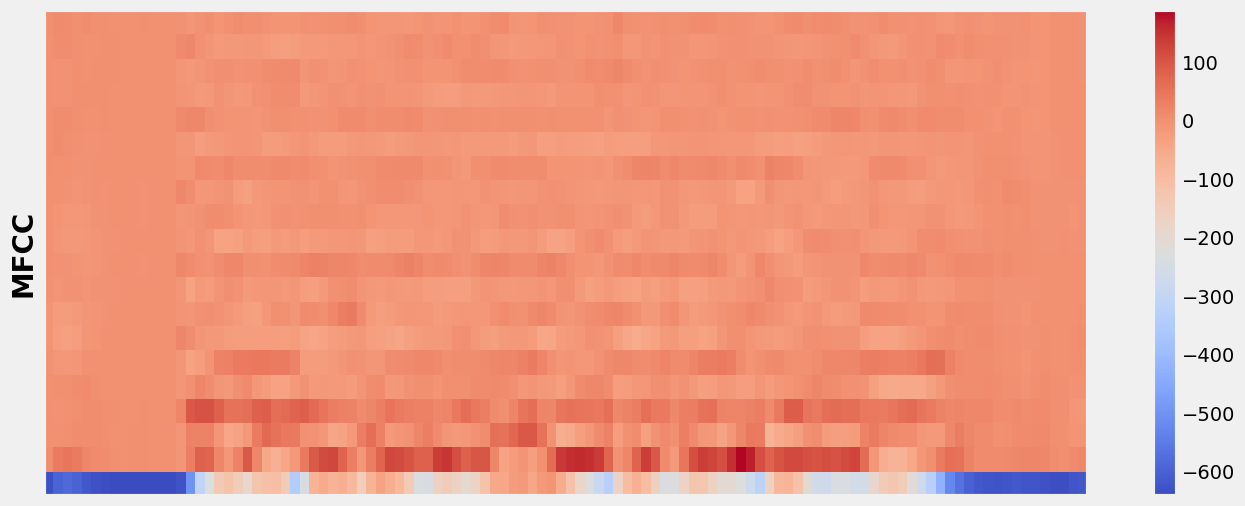

In [7]:
#Creating the MFCC for the audio
audio_array,sampling_rate = librosa.load(fl, sr=sample_rate) 
mfcc = librosa.feature.mfcc(y=audio_array, sr=sample_rate, n_mfcc = 20) #10 components
librosa.display.specshow(mfcc)
plt.ylabel('MFCC',fontsize = 20, loc='center', fontdict=dict(weight='bold'))
plt.colorbar()
plt.show() 

In [8]:
import time
# CHANGING THE AUDIO CLIPS TO MFCC IMAGES
output_folder = "D:/AMINA/PFE24/application/audio_imgs" # where the MFCC graph images will be saved.

# Define the interval for printing progress
print_interval = 2000
batch_start_time = time.time()

# Determine the maximum index from existing files in the output folder
existing_files = os.listdir(output_folder)
existing_indices = [int(filename.split('_')[0]) for filename in existing_files if filename.endswith('_mfcc.png')]
max_index_processed = max(existing_indices, default=-1)
'''''
for index, row in df.iloc[max_index_processed + 1:].iterrows():
    audio_path = row['filename']#Retrieves the filename (path to the audio clip)
    gender = row['gender']# Retrieves the gender info
    accent = row['accent']# Retrieves the accent info

    audio_array, sampling_rate = librosa.load(audio_path, sr=sample_rate)
    #Loads the audio clip from the specified audio_path and returns the audio waveform as an array
    mfcc = librosa.feature.mfcc(y=audio_array, sr=sample_rate, n_mfcc=20)
    #Computes the MFCC for the loaded audio_array with 16GHz and 20 components

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('MFCC')
    plt.xlabel('Time')
    plt.ylabel('MFCC Coefficients')

    # Extracts the filename of the audio clip (excluding the directory path)
    audio_clip_filename = os.path.basename(audio_path)
    
    # Saves the MFCC image with a unique name that combines:
    # the output folder + the index of the current row + the audio clip filename + the suffix "_mfcc.png".
    img_filename = os.path.join(output_folder, f'{index}_{audio_clip_filename}_mfcc.png')
    plt.savefig(img_filename)
    plt.close()

    # Print progress at intervals
    if index % print_interval == 0 and index != 0:
        batch_end_time = time.time()
        batch_processing_time = batch_end_time - batch_start_time
        print(f"Processed {index} rows out of {len(df)} in {batch_processing_time:.2f} seconds")
        batch_start_time = time.time()  # Reset the batch start time for the next interval
'''

Processed 114000 rows out of 126108 in 22.24 seconds
Processed 116000 rows out of 126108 in 377.08 seconds
Processed 118000 rows out of 126108 in 374.40 seconds
Processed 120000 rows out of 126108 in 399.04 seconds
Processed 122000 rows out of 126108 in 530.91 seconds
Processed 124000 rows out of 126108 in 476.23 seconds
Processed 126000 rows out of 126108 in 536.64 seconds


In [8]:
#Image preprocessing
#Splitting the data into training, testing, and validation sets
#StratifiedKFold takes into consideration the equal distribution of the target variable labels (age classes)
output_folder = "D:/AMINA/PFE24/application/audio_imgs"
progress_folder = "D:/AMINA/PFE24/application/"#bc system keeps crashing

# Check if progress file exists
progress_file = os.path.join(progress_folder, "progress.txt")
if os.path.exists(progress_file):
    with open(progress_file, 'r') as f:
        last_processed_batch = int(f.read().strip())
else:
    last_processed_batch = 0

image_paths = [os.path.join(output_folder, filename) for filename in os.listdir(output_folder) if filename.endswith('_mfcc.png')]

batch_size = 100 #100  images per batch
total_images = len(image_paths)
num_batches = (total_images + batch_size - 1) // batch_size

images = []

# Start processing from the last processed batch
for batch_idx in range(last_processed_batch, num_batches):
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, total_images)
    
    batch_paths = image_paths[start_idx:end_idx]
    batch_images = []
    
    for img_path in batch_paths:
        img = image.load_img(img_path)
        img = image.img_to_array(img)
        img = img / 255.0
        batch_images.append(img)
    
    images.extend(batch_images)
    print(f"Processed batch {batch_idx + 1}/{num_batches}")

    # Save progress after each batch
    with open(progress_file, 'w') as f:
        f.write(str(batch_idx + 1))

images = np.array(images)

Processed batch 1/1262
Processed batch 2/1262
Processed batch 3/1262
Processed batch 4/1262
Processed batch 5/1262
Processed batch 6/1262
Processed batch 7/1262
Processed batch 8/1262
Processed batch 9/1262
Processed batch 10/1262
Processed batch 11/1262
Processed batch 12/1262
Processed batch 13/1262
Processed batch 14/1262
Processed batch 15/1262
Processed batch 16/1262
Processed batch 17/1262
Processed batch 18/1262
Processed batch 19/1262
Processed batch 20/1262
Processed batch 21/1262
Processed batch 22/1262
Processed batch 23/1262
Processed batch 24/1262
Processed batch 25/1262
Processed batch 26/1262
Processed batch 27/1262
Processed batch 28/1262
Processed batch 29/1262
Processed batch 30/1262
Processed batch 31/1262
Processed batch 32/1262
Processed batch 33/1262
Processed batch 34/1262
Processed batch 35/1262
Processed batch 36/1262
Processed batch 37/1262
Processed batch 38/1262
Processed batch 39/1262
Processed batch 40/1262
Processed batch 41/1262
Processed batch 42/1262
P

In [ ]:
# Load audio features (MFCC) from your DataFrame
audio_features = df.iloc[:, :-1].values  # Exclude 'age' column

In [ ]:
# Combine image and audio data
X = np.concatenate((images, audio_features), axis=1)
# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['age'])

#bc StratifiedKFold doesn't split into 3 sets: 
#split into temp train set (split into train 60% + val 20% sets) + test set 20%
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

In [ ]:
#THE MODEL
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(1000, 400, 3)))  # All imgs are 1000x400 pixels
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(8, activation='softmax')) #8 = number of age classes

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Predict classes for the test data
y_pred = model.predict_classes(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# Print out the evaluation metrics results
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1)

In [ ]:
print("Confusion Matrix:")
print(conf_matrix)